In [29]:
# 전체 데이터 샘플링 버전
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dask.dataframe as dd

FILE_NAME_HEADER = "shared/data/fhv_tripdata_2024_1278/fhvhv_tripdata_2024-"

months = ['01', '01', '07', '08']
for month in months:
    file_path = f"{FILE_NAME_HEADER}{month}.parquet"
    ddf = dd.read_parquet(file_path)
    # Process the Dask DataFrame as needed
    # For example, you can compute it to a Pandas DataFrame if necessary
    # df = ddf.compute()

    fraction = 0.01
    sampled_df = ddf.sample(frac=fraction, random_state=42).compute()
    
    # Concatenate the sampled DataFrame to the main DataFrame
    if 'df' in locals():
        df = pd.concat([df, sampled_df], ignore_index=True)
    else:
        df = sampled_df

In [30]:
sample_df_all = df.reset_index(drop=True)

In [31]:
df.head()

,hvfhs_license_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,...,precipitation_y,max_C_y,min_C_y,dispatching_base_num,originating_base_num,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,2024-01-01 01:48:48,2024-01-01 01:50:14,2024-01-01 01:51:03,2024-01-01 02:04:52,79,233,2.39,13,35.08,...,0.03,8.3,1.7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,HV0003,2024-01-09 08:51:17,2024-01-09 08:53:57,2024-01-09 08:54:31,2024-01-09 09:07:00,71,72,1.75,12,10.66,...,1.73,13.9,2.2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,HV0003,2024-01-01 10:34:11,2024-01-01 10:40:38,2024-01-01 10:42:16,2024-01-01 11:41:25,132,265,38.90,59,136.89,...,0.03,8.3,1.7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,HV0003,2024-01-08 08:47:58,2024-01-08 08:53:18,2024-01-08 08:53:18,2024-01-08 09:25:12,112,177,4.53,31,32.23,...,0.00,7.2,2.2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,HV0003,2024-01-07 19:10:17,2024-01-07 19:12:17,2024-01-07 19:12:39,2024-01-07 19:17:43,263,141,0.89,5,8.19,...,0.24,3.3,1.1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [32]:
taxi_zone = pd.read_csv("/Users/admin/softeer_de_wiki/mission/W4/m2/shared/data/taxi_zone_lookup.csv")

In [33]:
taxi_zone.head(5)

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [34]:
columns = ['dispatching_base_num', 'originating_base_num', 'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag']
df = df.drop(columns=columns)

# dropoff_datetime - pickup_datetime <= 0 삭제
df = df[df['dropoff_datetime'] - df['pickup_datetime'] > pd.Timedelta(0)]
# on_scene_datetime - request_datetime <= 0 삭제
df = df[df['on_scene_datetime'] - df['request_datetime'] > pd.Timedelta(0)]
# base_passenger_fare <=0 삭제
df = df[df['base_passenger_fare'] > 0]
# driver_pay < 0 삭제
df = df[df['driver_pay'] >= 0]

df['Taxi_Company'] = df['hvfhs_license_num'].map({
    'HV0003': 'Uber',
    'HV0005': 'Lyft'
})

df['year'] = pd.to_datetime(df['pickup_datetime']).dt.year
df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month
df['day'] = pd.to_datetime(df['pickup_datetime']).dt.day
df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour

df['season'] = df['month'].map({
    1: 'Winter',
    2: 'Winter',
    7: 'Summer',
    8: 'Summer',
})

df['PULocation'] = df['PULocationID'].map(taxi_zone.set_index('LocationID')['Borough'])
df['DOLocation'] = df['DOLocationID'].map(taxi_zone.set_index('LocationID')['Borough'])

df['time_to_on_scene'] = round((df['on_scene_datetime'] - df['request_datetime']).dt.total_seconds() / 60)

df['trip_time'] = (df['trip_time'] / 60).astype(int)

df['trip_km'] = round(df['trip_miles'] * 1.60934, 2)

## 날씨

In [35]:
import glob
weather = pd.concat([pd.read_csv(f) for f in glob.glob("/Users/admin/softeer_de_wiki/mission/W4/m2/shared/data/2024_weather/*.csv")])

In [36]:
weather.head(5)

,year,month,day,max,min,precipitation1,precipitation2,precipitation3
0,2024,8,1,95,76,0.00,0.0,0.0
1,2024,8,2,92,74,0.52,0.0,0.0
2,2024,8,3,93,73,0.73,0.0,0.0
3,2024,8,4,83,71,0.17,0.0,0.0
4,2024,8,5,90,73,0.00,0.0,0.0


In [37]:
weather['precipitation1'] = weather['precipitation1'].replace('T', '0').astype(float)
weather['precipitation2'] = weather['precipitation2'].replace('T', '0').astype(float)
weather['precipitation3'] = weather['precipitation3'].replace('T', '0').astype(float)
weather['precipitation'] = weather[['precipitation1', 'precipitation2', 'precipitation3']].sum(axis=1)

weather = weather.drop(columns=['precipitation1', 'precipitation2', 'precipitation3'])

weather['max_C'] = ((weather['max'] - 32) * 5 / 9).round(1)
weather['min_C'] = ((weather['min'] - 32) * 5 / 9).round(1)

weather = weather.rename(columns={
    'max': 'max_F',
    'min': 'min_F'
})

In [38]:
df = df.merge(weather, on=['year', 'month', 'day'], how='left')

In [39]:
df.head()

,hvfhs_license_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,...,max_F_y,min_F_y,precipitation_y,max_C_y,min_C_y,max_F,min_F,precipitation,max_C,min_C
0,HV0003,2024-01-01 01:48:48,2024-01-01 01:50:14,2024-01-01 01:51:03,2024-01-01 02:04:52,79,233,2.39,0,35.08,...,47.0,35.0,0.03,8.3,1.7,47,35,0.03,8.3,1.7
1,HV0003,2024-01-09 08:51:17,2024-01-09 08:53:57,2024-01-09 08:54:31,2024-01-09 09:07:00,71,72,1.75,0,10.66,...,57.0,36.0,1.73,13.9,2.2,57,36,1.73,13.9,2.2
2,HV0003,2024-01-01 10:34:11,2024-01-01 10:40:38,2024-01-01 10:42:16,2024-01-01 11:41:25,132,265,38.90,0,136.89,...,47.0,35.0,0.03,8.3,1.7,47,35,0.03,8.3,1.7
3,HV0003,2024-01-08 08:47:58,2024-01-08 08:53:18,2024-01-08 08:53:18,2024-01-08 09:25:12,112,177,4.53,0,32.23,...,45.0,36.0,0.00,7.2,2.2,45,36,0.00,7.2,2.2
4,HV0003,2024-01-07 19:10:17,2024-01-07 19:12:17,2024-01-07 19:12:39,2024-01-07 19:17:43,263,141,0.89,0,8.19,...,38.0,34.0,0.24,3.3,1.1,38,34,0.24,3.3,1.1


In [40]:
df['season'].value_counts()

season
Winter    857682
Summer    844452
Name: count, dtype: int64

In [41]:
# 과제 파트

# Average Trip Duration
average_trip_duration = df['trip_time'].mean().round(2)

# Average Trip Distance
average_trip_distance_km = df['trip_km'].mean().round(2)
average_trip_distance_miles = df['trip_miles'].mean().round(2)

# Peak Hours
peak_hours = df['pickup_datetime'].dt.hour.value_counts().sort_values(ascending=False)

In [42]:
print("Average Trip Duration (minutes):", average_trip_duration, "minutes")
print("Average Trip Distance (km):", average_trip_distance_km, "km")
print("Average Trip Distance (miles):", average_trip_distance_miles, "miles")
print()
print("Peak Hours Distribution:")
print(pd.DataFrame(peak_hours).head(10))

Average Trip Duration (minutes): 6.19 minutes
Average Trip Distance (km): 8.0 km
Average Trip Distance (miles): 4.97 miles

Peak Hours Distribution:
                  count
pickup_datetime        
18               104694
17               100818
19                99510
20                93321
21                91983
22                89964
16                89613
15                86331
8                 85803
14                85119


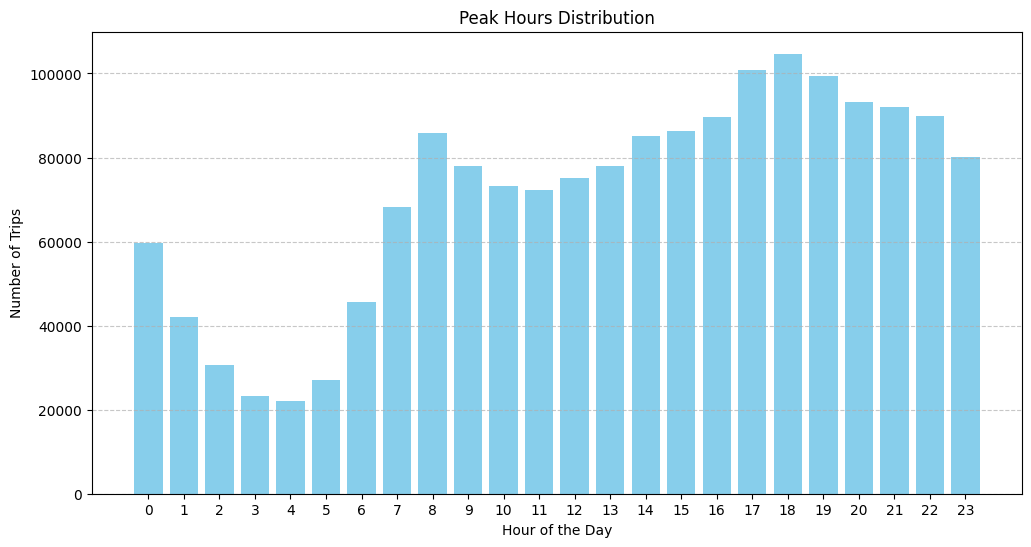

In [43]:
plt.figure(figsize=(12, 6))
plt.bar(peak_hours.index, peak_hours.values, color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Peak Hours Distribution')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [44]:
weather = pd.concat([pd.read_csv(f) for f in glob.glob("/Users/admin/softeer_de_wiki/mission/W4/m2/shared/data/2024_weather/*.csv")])

In [45]:
weather['precipitation1'] = weather['precipitation1'].replace('T', '0').astype(float)
weather['precipitation2'] = weather['precipitation2'].replace('T', '0').astype(float)
weather['precipitation3'] = weather['precipitation3'].replace('T', '0').astype(float)
weather['precipitation'] = weather[['precipitation1', 'precipitation2', 'precipitation3']].sum(axis=1)

weather = weather.drop(columns=['precipitation1', 'precipitation2', 'precipitation3'])

weather['max_C'] = ((weather['max'] - 32) * 5 / 9).round(1)
weather['min_C'] = ((weather['min'] - 32) * 5 / 9).round(1)

weather = weather.rename(columns={
    'max': 'max_F',
    'min': 'min_F'
})

In [46]:
weather.head(5)

,year,month,day,max_F,min_F,precipitation,max_C,min_C
0,2024,8,1,95,76,0.00,35.0,24.4
1,2024,8,2,92,74,0.52,33.3,23.3
2,2024,8,3,93,73,0.73,33.9,22.8
3,2024,8,4,83,71,0.17,28.3,21.7
4,2024,8,5,90,73,0.00,32.2,22.8


In [47]:
df = df.merge(weather, on=['year', 'month', 'day'], how='left')

MergeError: Passing 'suffixes' which cause duplicate columns {'max_F_x', 'min_F_x', 'precipitation_x', 'max_C_x', 'min_C_x'} is not allowed.

In [48]:
df.head(5)

,hvfhs_license_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,...,max_F_y,min_F_y,precipitation_y,max_C_y,min_C_y,max_F,min_F,precipitation,max_C,min_C
0,HV0003,2024-01-01 01:48:48,2024-01-01 01:50:14,2024-01-01 01:51:03,2024-01-01 02:04:52,79,233,2.39,0,35.08,...,47.0,35.0,0.03,8.3,1.7,47,35,0.03,8.3,1.7
1,HV0003,2024-01-09 08:51:17,2024-01-09 08:53:57,2024-01-09 08:54:31,2024-01-09 09:07:00,71,72,1.75,0,10.66,...,57.0,36.0,1.73,13.9,2.2,57,36,1.73,13.9,2.2
2,HV0003,2024-01-01 10:34:11,2024-01-01 10:40:38,2024-01-01 10:42:16,2024-01-01 11:41:25,132,265,38.90,0,136.89,...,47.0,35.0,0.03,8.3,1.7,47,35,0.03,8.3,1.7
3,HV0003,2024-01-08 08:47:58,2024-01-08 08:53:18,2024-01-08 08:53:18,2024-01-08 09:25:12,112,177,4.53,0,32.23,...,45.0,36.0,0.00,7.2,2.2,45,36,0.00,7.2,2.2
4,HV0003,2024-01-07 19:10:17,2024-01-07 19:12:17,2024-01-07 19:12:39,2024-01-07 19:17:43,263,141,0.89,0,8.19,...,38.0,34.0,0.24,3.3,1.1,38,34,0.24,3.3,1.1


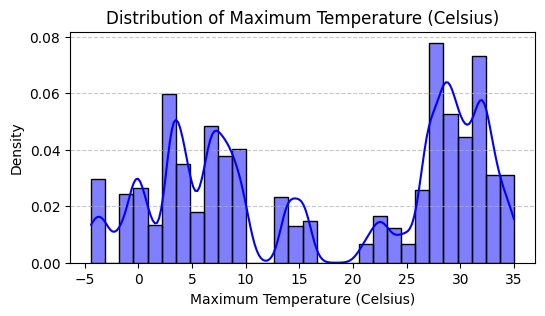

In [51]:
import seaborn as sns

plt.figure(figsize=(6, 3))
sns.histplot(data=df, x='max_C', bins=30, kde=True, color='blue', stat='density')
plt.title('Distribution of Maximum Temperature (Celsius)')
plt.xlabel('Maximum Temperature (Celsius)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

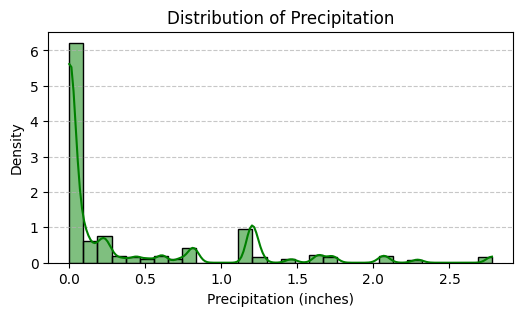

In [52]:
plt.figure(figsize=(6, 3))
sns.histplot(data=df, x='precipitation', bins=30, kde=True, color='green', stat='density')
plt.title('Distribution of Precipitation')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()